<a href="https://colab.research.google.com/github/abhishekverma0207/abhishekverma_ljmu/blob/main/M5/M5_Databuildup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [5]:
!kaggle competitions download -c m5-forecasting-accuracy

 72% 33.0M/45.8M [00:00<00:00, 72.9MB/s]
100% 45.8M/45.8M [00:00<00:00, 83.1MB/s]


In [6]:
!unzip *.zip
!rm *.zip

Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


https://www.kaggle.com/code/mubashir1/one-tutorial-to-understand-all-m5-forecasting/notebook

https://www.kaggle.com/code/tarunpaparaju/m5-competition-eda-models/notebook

https://github.com/Mcompetitions/M5-methods/tree/master/Code%20of%20Winning%20Methods


# Data loading

#### Installing dependent packages

In [ ]:
!pip install lightning
!pip install pytorch_forecasting

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time
import math
import datetime
# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal


# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from lightning.pytorch.loggers import TensorBoardLogger
# import numpy as np
# import pandas as pd
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet


#### Reading Data

In [8]:
INPUT_DIR = '/content'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

In [9]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [12]:
selling_prices['item_id'].nunique()

3049

In [13]:
selling_prices.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [11]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [15]:
sales_train_val['id'].nunique()

30490

*Now that we have taken a look at the data provided and have a general understanding of the dataset, we can see various relationships between the stores, the specific products sold, the categories that the consumers are most interested in as well as the sale of items per specific locale.*

**Sell_prices_df contains information along the store level of some 6 million entries.<br>
Train_sales_df has informaiton about some 30,000 different products.**

Furthermore, the dataset in the calendar_df makes it possible to do a time series analysis of the products sold.

**Questions on Distribution of Product & Behavior Across Timeline** <br>

Starting with the dataframe denoted by sales_train_val that has the item specific ('id'), locale specific ('store_id' , 'state_id') and sales days specific (d_1 to d_1913) information; <br> let us first make necessary adjustments to separate the sales days so that analysis along item_id, store_id and dept_id can be more easily observed across sales days only.

In [16]:
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
sales_train_val['total_sales_all_days'] = sales_train_val[d_cols].sum(axis = 1)
sales_train_val['avg_sales_all_days'] = sales_train_val[d_cols].mean(axis = 1)
sales_train_val['median_sales_all_days'] = sales_train_val[d_cols].median(axis = 1)

In [18]:
# Distribution of product_id by categories
df = sales_train_val.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id',
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Product_IDs Across Categories')
fig.show()



*   We can see that Food items are maximum soldout items
*   Household items is second most sold category followed by Hobbies



In [20]:
df = sales_train_val.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id',
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Total_Sales Distribution Across States')
fig.show()

Looking at the sales data and analyzing which states have the highest number of items sold and revenue earned. <br> CA leads in both categories, followed by Texas and Wisconsin. <br>
Let's analyse this using the revenue dataframe?

In [21]:
df1 = sales_train_val.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = sales_train_val.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

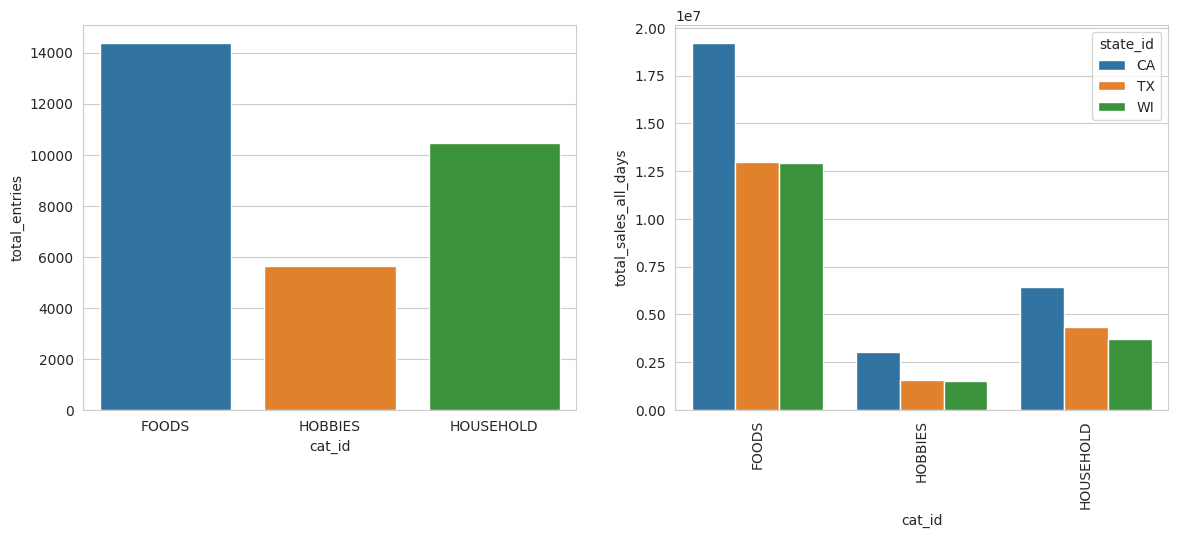

In [29]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, ax=ax2)
plt.xticks(rotation=90)
plt.show()

The above two plots indicate:

* Most items sold belong to the FOODS category, followed by HOUSEHOLD and HOBBIES
* CA leads in the number of "Total items" sold in either category (FOODS, HOBBIES AND HOUSEHOLD) , while WISCONSIN lags behind TX in each category except FOODS. We would see whether the same difference translates in terms of revenue extracted off these states or not

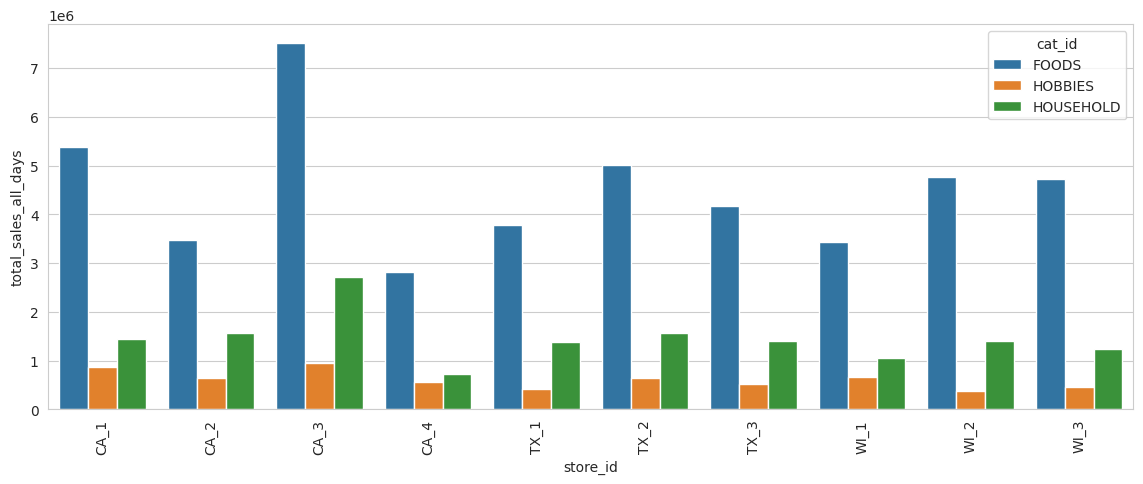

In [31]:
df3 = sales_train_val.groupby(['cat_id', 'store_id'])['total_sales_all_days'].sum().reset_index()
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, ax1 = plt.subplots(figsize=(14,5))

sns.barplot(x = 'store_id', y='total_sales_all_days', hue='cat_id', data=df3, ax=ax1)

plt.xticks(rotation=90)
plt.show()


In [32]:
df = sales_train_val.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category",
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

In [33]:
df = sales_train_val.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[sales_train_val.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)


x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):

    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier

    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown),
            title (title of the plot)

    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific
    number of days
    '''

    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}],
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450,
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]);

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')


In [34]:
sales_train_val.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

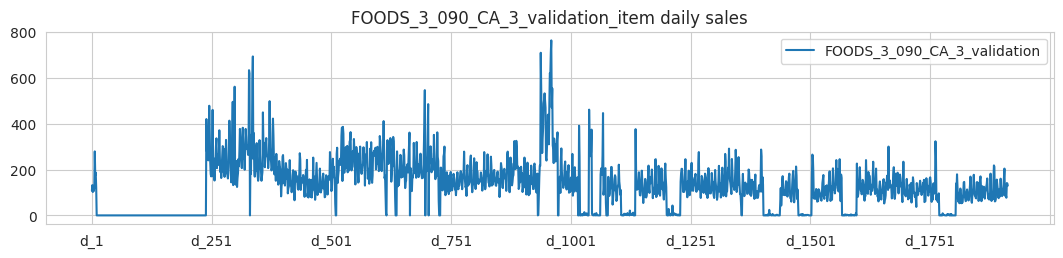

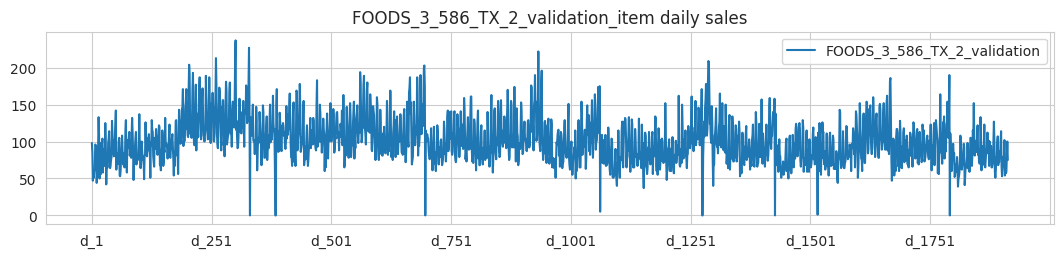

In [37]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id

    input: spec_id
    returns : number of sales plotted across number of days
    """
    sales_train_val.loc[sales_train_val['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales"
                    )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation')
plot_dailysales('FOODS_3_586_TX_2_validation')


# New Section